In [11]:
import torch
from torch import nn
from d2l import torch as d2l

In [12]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

In [13]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if self.plot_flag:
            self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        if self.plot_flag:
            self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
            self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        return l
    
data = d2l.FashionMNIST(batch_size=256)

1. What happens if you change the dropout probabilities for the first and second layers? In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize the qualitative takeaways.

(1) dropout1 = 0.5, dropout2 = 0.5

0.8079000115394592


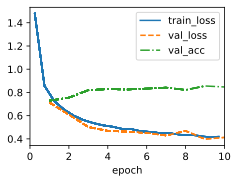

In [4]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

(2) dropout1 = 0.1, dropout2 = 0.5

0.7465999722480774


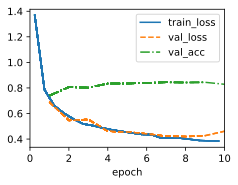

In [5]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.1, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

(3) dropout1 = 0.5, dropout2 = 0.1

0.7958999872207642


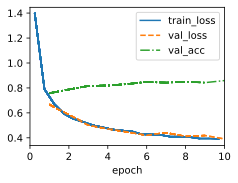

In [6]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.1, 'lr':0.1}
model = DropoutMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

(4) dropout1 = 0.5, dropout2 = 0.2

0.7616999745368958


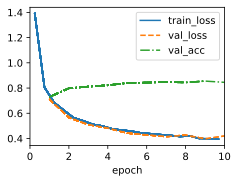

In [8]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.2, 'lr':0.1}
model = DropoutMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

(3) dropout1 = 0.2, dropout2 = 0.5

0.7976999878883362


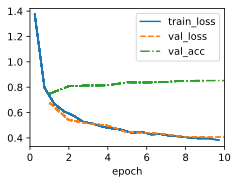

In [9]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.2, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

From the results above, the accuracy didn't change much. I can't come up with a rule.

2. Increase the number of epochs and compare the results obtained when using dropout with those when not using it.

(1) Using dropout:

0.8166000247001648


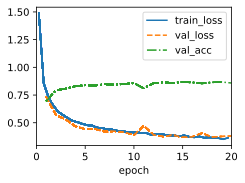

In [7]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLP(**hparams)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

(2) Not using dropout:

0.8424000144004822


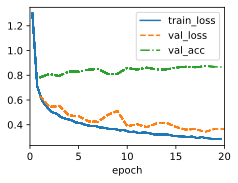

In [10]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0, 'dropout_2':0, 'lr':0.1}
model = DropoutMLP(**hparams)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

While not using dropout layer, the training loss is smaller than validation loss, indicating there is overfitting.

3. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.

Suppose the output of the i th hidden layer is $h^{(i)}$, $h^{(0)}=X$. The output after the dropout layer is ${h'}^{(i)}$

$$Var({h'}^{(i)}) = E({h'}^{2}) - E(h')^{2} = \frac{1}{1-p}E(h^2) - E(h)^2 = \frac{p}{1-p} E(h^2) + Var(h)$$

It will increase the variance ?

In [3]:
class PlotActMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, dropouts):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        self.activations = []
        for i in range(len(num_hiddens)):
            layers.append(nn.LazyLinear(num_hiddens[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropouts[i]))
            self.activations.append(i*3+4)
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)
        
    def training_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        # auc = torch.tensor(roc_auc_score(batch[-1].detach().numpy() , y_hat[:,1].detach().numpy()))
        if plot_flag:
            for i in self.activations:
                for j in range(2):
                    var = self.stat_activation_variance(i-j, *batch[:-1])
                    self.plot(f'layer_{i-j}',var,train=True)
            # self.plot('loss', self.loss(y_hat, batch[-1]), train=True)
            # self.plot('auc', auc, train=True)
            # self.plot('acc', self.accuracy(y_hat, batch[-1]), train=True)
        return self.loss(y_hat, batch[-1])
        
    def validation_step(self, batch, plot_flag=True):
        y_hat = self(*batch[:-1])
        # auc = torch.tensor(roc_auc_score(batch[-1].detach().numpy() , y_hat[:,1].detach().numpy()))
        # if plot_flag:
            # self.plot('loss', self.loss(y_hat, batch[-1]), train=False)
            # self.plot('auc', auc, train=True)
            # self.plot('acc', self.accuracy(y_hat, batch[-1]), train=False)
        return self.loss(y_hat, batch[-1])
    
    def stat_activation_variance(self, i, X):
        activation = self.net[:i](X)
        return ((activation-activation.mean(axis=0,keepdim=True))**2).mean()

(1) Using dropout, the variance of output of the dropout layer(4,7) is larger than layer(3,6).

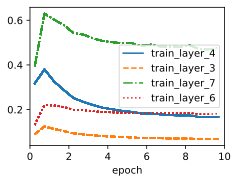

In [4]:
hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':[0.5]*2,'lr':0.1}
model = PlotActMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

(2) Without dropout, the variance stay the same.

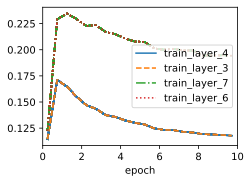

In [5]:
hparams = {'num_outputs':10,'num_hiddens':[256]*2,
           'dropouts':[0]*2,'lr':0.1}
model = PlotActMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

4. Why is dropout not typically used at test time?

During training, dropout works by randomly deactivating a fraction of neurons in each layer with a certain probability. This process helps prevent the network from relying too heavily on specific neurons and encourages the network to learn more robust and generalized features. During inference (test time), the goal is to make predictions on new, unseen data, and dropout doesn’t serve the same purpose. Applying dropout at test time would introduce randomness into the predictions, which is undesirable.

5. Using the model in this section as an example, compare the effects of using dropout and weight decay. What happens when dropout and weight decay are used at the same time? Are the results additive? Are there diminished returns (or worse)? Do they cancel each other out?

The effects of using dropout and weight decay are not always additive or consistent. They depend on various factors and require careful tuning and experimentation. A possible guideline is to use dropout when the network is very large and complex compared to the amount of data, and use weight decay when the network is relatively simple or the data is abundant. 

(1) Using dropout:

0.8101000189781189


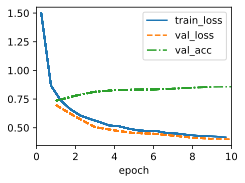

In [6]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

(2) Using weight-decay:

0.7139999866485596


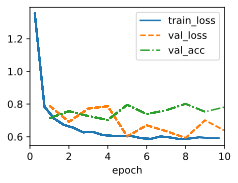

In [10]:
class WeightDecayMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2, lr, wd, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(), 
            nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.LazyLinear(num_outputs))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if self.plot_flag:
            self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        if self.plot_flag:
            self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
            self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        return l
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.wd)

hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'wd':0.02, 'lr':0.1}
model = WeightDecayMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

(3) Using dropout and weight decay:

0.796500027179718


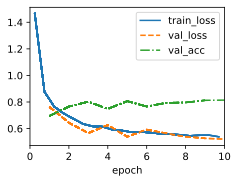

In [12]:
class WeightDecayDropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr, wd, plot_flag=True):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if self.plot_flag:
            self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        if self.plot_flag:
            self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
            self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        return l
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.wd)

hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'wd':0.01, 'lr':0.1}
model = WeightDecayDropoutMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())

It seems that neither using dropout or weight decay working very well in this case. The accuracy without them is higher.

6. What happens if we apply dropout to the individual weights of the weight matrix rather than the activations?

If we apply dropout to the individual weights of the weight matrix rather than the activations, we are using a technique called dropconnect. Dropconnect requires more memory and computation to implement, as it needs to store and update a mask matrix for each weight matrix.

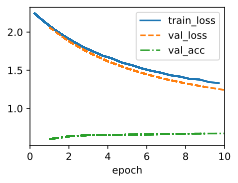

In [21]:
class DropoutWeightMLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.Linear(num_inputs, num_hiddens_1)
        self.lin2 = nn.Linear(num_hiddens_1, num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        X = X.reshape((X.shape[0], -1))
        w1 = self.lin1.weight.data
        if self.training:
            w1 = dropout_layer(w1, self.dropout_1)
        H1 = self.relu(torch.matmul(X, w1.T) + self.lin1.bias.data)
        w2 = self.lin2.weight.data
        if self.training:
            w2 = dropout_layer(w2, self.dropout_2)
        H2 = self.relu(torch.matmul(H1, w2.T) + self.lin2.bias.data)
        return self.lin3(H2)

hparams = {'num_inputs':28*28, 'num_outputs':10,'num_hiddens_1':256, 'num_hiddens_2': 256,
           'dropout_1':0.2, 'dropout_2':0.2, 'lr':0.1}
model = DropoutWeightMLPScratch(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

7. Invent another technique for injecting random noise at each layer that is different from the standard dropout technique. Can you develop a method that outperforms dropout on the Fashion-MNIST dataset (for a fixed architecture)?

My dropout funtion:

$$h' = h * (1 + \epsilon)$$

where $\epsilon \sim N(0, \sigma^2)$

0.828000009059906


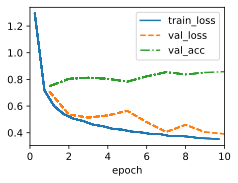

In [6]:
def dropout_layer_new(X, dropout):
    noise = torch.randn(X.shape) * dropout
    return X * (1.0 + noise)

class NewDropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer_new(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer_new(H2, self.dropout_2)
        return self.lin3(H2)

hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.1, 'dropout_2':0.05, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
y_hat = model(data.val.data.type(torch.float32))
print(model.accuracy(y_hat,data.val.targets).item())
